In [1]:
using Pkg
Pkg.add("Unitful")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("DSP")
Pkg.add("GR")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %14.5 %>                            ]  28.9 % [==================>                      ]  43.4 %]  52.4 %===========================>             ]  66.9 %81.2 %> ]  95.7 % Resolving package versions...
 Installed BinaryProvider ─ v0.4.2
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [b99e7846] ↑ BinaryProvider v0.4.1 ⇒ v0.4.2
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Proje

In [2]:
using Unitful: m, Length, N, inch,rad,°,@u_str,lbf, lb,s, ustrip, psi,uconvert
using CSV
using DataFrames
using DSP
using GR

# Bar Info
Very average information on bar actually, nothing new here
Unit packages are freaking nice, obviously. Is your input in inches? cm? miles? run- |>u"m", now it is in meters.

In [3]:
#approximate, but close enough
function yeild_strength_to_shear_yeild(yeild_strength)
    yeild_strength*.58
end
bar_diameter=.75u"inch"|>u"m"
bar_radius=bar_diameter/2
poisson_ratio=.33
youngs_modulus=29*(10^6)u"psi"|>u"Pa"
bar_density= .284u"lb/inch^3"|>u"kg/m^3"
transmitted_strain_gauge_distance=36u"inch"|>u"m"
incident_strain_gauge_distance=24u"inch"|>u"m"
yeild_strength=50800u"psi"|>u"Pa"
shear_yeild_strength=yeild_strength_to_shear_yeild(yeild_strength)


2.0314712888591257e8 Pa

# Shot information
Two big driving variables, length of bar twisted and how far the bar was twisted

In [4]:
length_of_bar_twisted=12u"inch"|>u"m"
twist_angle=20u"°"|>u"rad"

0.3490658503988659 rad

In [5]:
function compute_shear_modulus(youngs_modulus,poisson_ratio)
    youngs_modulus/2/(1+poisson_ratio)
end
shear_modulus= compute_shear_modulus(youngs_modulus,poisson_ratio)
shear_wave_speed=√((shear_modulus|>u"(kg*m/s^2)/m^2")/(bar_density))

3092.2614529263633 m s^-1

# Shot Prediction
Note shear strain is in radians. That is not a typo.
The incident pulse would be twice the duration of crossing the twisted area,


In [6]:
#Important function
function polar_moment_inertia_bar(bar_radius)
    π*bar_radius^4/2
end
#Important function
function surface_strain_to_bar_torque(surface_strain,bar_radius,shear_modulus)
    torque_bar=(shear_modulus|>u"N/m^2")*polar_moment_inertia_bar(bar_radius)*surface_strain/bar_radius
end
function bar_torque_to_surface_strain(torque_bar,bar_radius,shear_modulus)
    torque_bar*bar_radius/((shear_modulus|>u"N/m^2")*polar_moment_inertia_bar(bar_radius))
end
#counter part of "speed limit" for shear test- how much can you torque the bar befor it dies?
function predicted_max_torque(shear_yeild_strength,bar_radius)
    (shear_yeild_strength|>u"N/m^2")*polar_moment_inertia_bar(bar_radius)/bar_radius
end
function predicted_strain_of_shot(bar_radius,twist_angle,length_of_bar_twisted)
    bar_radius*twist_angle/length_of_bar_twisted
end
shear_strain_surface=bar_radius*twist_angle/length_of_bar_twisted
duration_pulse= 2*length_of_bar_twisted/shear_wave_speed
shear_stress_surface=ustrip(shear_strain_surface)*shear_modulus*bar_radius
J_bar=polar_moment_inertia_bar(bar_radius)
torque_bar=surface_strain_to_bar_torque(shear_strain_surface,bar_radius,shear_modulus)
predicted_max_torque(shear_yeild_strength,bar_radius)

275.7563479951892 m N

# Sample parameters
The sample is a tube or a hollow cylinder of metal

In [7]:
sample_inner_diameter=10u"mm"|>u"m"
sample_outer_diameter=12u"mm"|>u"m"
sample_length=5u"mm" |>u"m"
sample_mean_radius=(sample_inner_diameter+sample_outer_diameter)/4
sample_thickness=(sample_outer_diameter-sample_inner_diameter)/2
sample_youngs_modulus=10*(10^6)u"psi"|>u"Pa"
sample_shear_modulus=compute_shear_modulus(sample_youngs_modulus,.33)

#this isnt a parameter
sample_flow_shear_stress=200u"MPa"

200 MPa

In [8]:
#Important function
function polar_moment_of_tube(inner_radius,outer_radius)
    polar_moment_inertia_bar(outer_radius)-polar_moment_inertia_bar(inner_radius)
end
function sample_stress_to_sample_torque(sample_outer_diameter,sample_inner_diameter,shear_stress)
    moment_of_inertia=polar_moment_of_tube(sample_inner_diameter/2,sample_outer_diameter/2)
    torque_sample=(shear_stress|>u"N/m^2")*moment_of_inertia/((sample_outer_diameter+sample_inner_diameter)/4)
end
#Important function
function sample_torque_to_sample_stress(torque_sample,sample_outer_diameter,sample_inner_diameter)
    moment_of_inertia=polar_moment_of_tube(sample_inner_diameter/2,sample_outer_diameter/2)
    torque_sample/moment_of_inertia*((sample_outer_diameter+sample_inner_diameter)/4)
end
#incident and reflected pulses to sample shear strain rate
function compute_shear_strain_rate(reflected_shear_strain,bar_diameter,sample_average_diameter,
        shear_wave_speed,length_of_sample)
    4*(sample_average_diameter/2)*shear_wave_speed/(bar_diameter/2*length_of_sample)*(reflected_shear_strain) 
end

compute_shear_strain_rate (generic function with 1 method)

# Simulated Shot  
Twist 12 inches of bar 2 degrees  
sample as described above.  
Expect flow stress of 200 MPa  
total strain of .66, strain rate of 3360  


In [9]:
length_of_bar_twisted=12u"inch"|>u"m"
twist_angle=2u"°"|>u"rad"

0.03490658503988659 rad

In [10]:
transmitted_torque=sample_stress_to_sample_torque(sample_outer_diameter,sample_inner_diameter,sample_flow_shear_stress)
transmitted_strain=bar_torque_to_surface_strain(transmitted_torque,bar_radius,shear_modulus)
predicted_strain=predicted_strain_of_shot(bar_radius,twist_angle,length_of_bar_twisted)
reflected_strain=predicted_strain-transmitted_strain
compute_shear_strain_rate(reflected_strain,bar_diameter,sample_mean_radius*2,
        shear_wave_speed,sample_length)

1021.6267810323542 s^-1

In [11]:
lead_time=collect(0u"s":1u"μs":0.0001u"s")
duration_pulse=length_of_bar_twisted*2/shear_wave_speed
lead_in=map(time->0.0,0u"s":1u"μs":0.0001u"s")
incident_pulse=map(time->ustrip(predicted_strain),0u"s":1u"μs":duration_pulse)
gap=map(time->0.0,0u"s":1u"μs":(2*incident_strain_gauge_distance/shear_wave_speed))
reflected_pulse = map(time->-ustrip(reflected_strain),0u"s":1u"μs":duration_pulse)
end_out=map(time->0.0,0u"s":1u"μs":0.0001u"s")
transmitted_pulse=map(time->ustrip(transmitted_strain),0u"s":1u"μs":duration_pulse)
gap_transmitted=map(time->0.0,0u"s":1u"μs":(1u"μs"+2*incident_strain_gauge_distance/shear_wave_speed+duration_pulse))

time=map(time->ustrip(time),0u"s":1u"μs":(4u"μs"+0.0001u"s"*2+duration_pulse*2+(2*incident_strain_gauge_distance/shear_wave_speed)))
#quick little filter so it doesn't look dumb
proto=Butterworth(1)
zpk = digitalfilter(Lowpass(0.2), proto)
tf = convert(PolynomialRatio, zpk)

incident_bar_strain_history=filt(tf,cat(dims=1,lead_in,incident_pulse,gap,reflected_pulse,end_out))
transmitted_bar_strain_history=filt(tf,cat(dims=1,lead_in,gap_transmitted,transmitted_pulse,end_out));

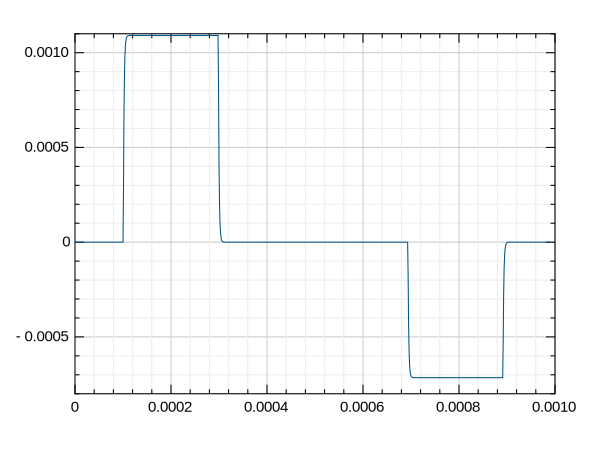

In [12]:
GR.setviewport(0.1, 0.95, 0.1, 0.95)
GR.setwindow(-2, 2, -2, 2)
GR.setspace(-0.5, 0.5, 0, 90)
GR.setmarkersize(1)
GR.setmarkertype(-1)
GR.setcharheight(0.024)
GR.settextalign(2, 0)
GR.settextfontprec(3, 0)


plot(time,incident_bar_strain_history)



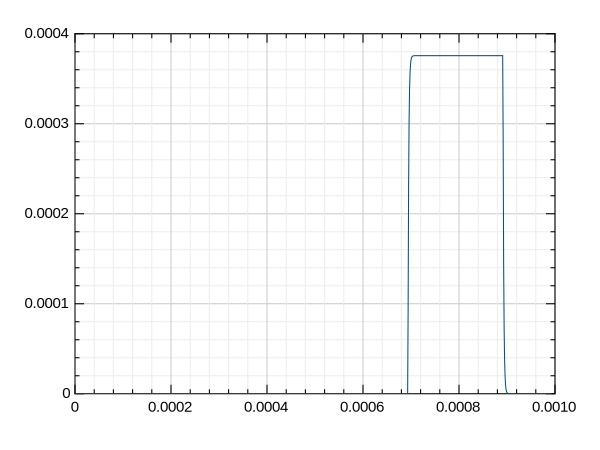

In [13]:
GR.setviewport(0.1, 0.95, 0.1, 0.95)
GR.setwindow(-2, 2, -2, 2)
GR.setspace(-0.5, 0.5, 0, 90)
GR.setmarkersize(1)
GR.setmarkertype(-1)
GR.setcharheight(0.024)
GR.settextalign(2, 0)
GR.settextfontprec(3, 0)

plot(time,transmitted_bar_strain_history)

In [14]:
data_frame=DataFrame(time_seconds=time,incident_strain_gauge=incident_bar_strain_history,transmitted_strain_gauge=transmitted_bar_strain_history)
CSV.write("example_data.csv",data_frame)

CSV.Sink{Nothing,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: 
        decimal: '.'
        truestring: 'true'
        falsestring: 'false'
        internstrings: true, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "example_data.csv", 60, true, ["time_seconds", "incident_strain_gauge", "transmitted_strain_gauge"], 3, false, Val{false})